In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [13]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os


In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [15]:
sys.path.append('../')

In [16]:
import phononet as pn

In [17]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 1764.49it/s]


In [18]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [19]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

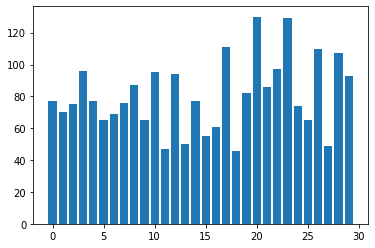

In [20]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [21]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

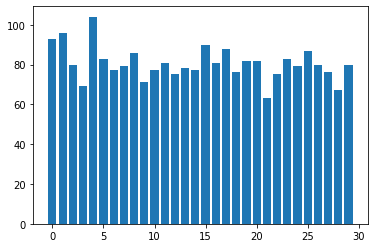

In [22]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [34]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        #print('balanced')
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        #print('not balanced')
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            #print('aug')
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            #print('not aug')
            yield X[idx],y[idx]




In [35]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [36]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes,print_f1=True,print_precision=False,print_recall=False, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        self.print_f1=print_f1
        self.print_precision=print_precision
        self.print_recall=print_recall
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            if self.print_precision:
                output['precision_{}'.format(i)]=results[0][i]
            if self.print_recall:
                output['recall_{}'.format(i)]=results[1][i]
            if self.print_f1:
                output['F1_{}'.format(i)]=results[2][i]

In [37]:
class MySequential(keras.Sequential):
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)
        return output
        
        
    def test_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        y_pred = self(x, training=False)  # Forward pass
        # Compute the loss value.
        # The loss function is configured in `compile()`.
        loss = self.compiled_loss(
            y,
            y_pred,
            regularization_losses=self.losses,
        )

        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)    
        return output

In [38]:
from tensorflow.keras.models import Sequential

In [39]:
class PeriodicPaddingConv2D(keras.layers.Conv2D):
    
    # Note this ONLY works now for filter size 3 and stride of 1
    
    def __init__(self,*args,**kwargs):
        padding_val=kwargs.pop('padding',None)
        if padding_val=='same':
            print('For PeriodPaddingConv2D padding must be valid so setting it to valid.')
            
            # TODO: padding is the same in all directions and we thus loose length in the time direction
            # Should not be a big deal but we can change this by padding zeros explicitely.
            kwargs['padding']='valid'
        super().__init__(*args,**kwargs)
            
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        x=tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))
        return super().call(x)
    



In [40]:
from tensorflow.keras.layers import Conv2D

In [41]:
ConvLayer=Conv2D

In [42]:
class OnlyTimeConvolution(tf.keras.layers.Layer):
    
    def __init__(self,num_filters,filter_size,shape,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.shape=shape
        self.tr1=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.tr2=keras.layers.Lambda(lambda x: tf.transpose(x,[0,2,1,3]))
        self.c=tf.keras.layers.Conv1D(num_filters,
                               filter_size,
                               data_format='channels_last', 
                               input_shape=(self.shape[1],3),*args,**kwargs)
        
    def call(self,x):
        x=self.tr1(x)
        x=tf.stack([self.c(x[:,:,i]) for i in range(self.shape[0])],2)
        x=self.tr2(x)
        return x

In [48]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    OnlyTimeConvolution(8,25,(12,1500),name='only_time_convolution',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
    keras.layers.BatchNormalization(axis=[3]),
    OnlyTimeConvolution(16,25,(12,1476),name='only_time_convolution2',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
    keras.layers.BatchNormalization(axis=[3]),
    OnlyTimeConvolution(32,25,(12,1452),name='only_time_convolution3',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
    keras.layers.BatchNormalization(axis=[3]),
    keras.layers.MaxPool2D((1,3),name='pool0'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(64,(3,3),name='conv1',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu1'),
    keras.layers.BatchNormalization(name='norm1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2),name='pool1'),
    keras.layers.Dropout(dropout_prob,name='drop1'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(128,(3,3),name='conv2',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu2'),
    keras.layers.BatchNormalization(name='norm2',axis=[3]),
    keras.layers.MaxPool2D((1,3),name='pool2'),
    keras.layers.Dropout(dropout_prob,name='drop2'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(150,(3,3),name='conv3',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu3'),
    keras.layers.BatchNormalization(name='norm3',axis=[3]),
    keras.layers.MaxPool2D((1,2),name='pool3'),
    keras.layers.Dropout(dropout_prob,name='drop3'),
    #
    ConvLayer(200,(3,3),name='conv4',padding='same',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu4'),
    keras.layers.BatchNormalization(name='norm4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
only_time_convolution (OnlyT (None, 12, 1476, 8)       208       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 12, 1476, 8)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 1476, 8)       32        
_________________________________________________________________
only_time_convolution2 (Only (None, 12, 1452, 16)      3216      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 12, 1452, 16)  

In [49]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [50]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
75/75 [==============================] - 13s 175ms/step - loss: 3.4167 - accuracy: 0.0608 - F1_0: 0.0545 - F1_1: 0.1388 - F1_2: 0.0560 - F1_3: 6.9033e-04 - F1_4: 0.0000e+00 - F1_5: 0.0047 - F1_6: 0.0029 - F1_7: 0.0632 - F1_8: 0.0741 - F1_9: 0.0035 - F1_10: 0.0000e+00 - F1_11: 0.0870 - F1_12: 0.0053 - F1_13: 0.0648 - F1_14: 0.0192 - F1_15: 0.1651 - F1_16: 0.0407 - F1_17: 0.0531 - F1_18: 0.0698 - F1_19: 0.0604 - F1_20: 0.0519 - F1_21: 0.0616 - F1_22: 0.0017 - F1_23: 0.0351 - F1_24: 0.0454 - F1_25: 0.0454 - F1_26: 0.0646 - F1_27: 0.0549 - F1_28: 0.0928 - F1_29: 0.0150 - val_loss: 4.1594 - val_accuracy: 0.0290 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0455 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0569 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e+00 - val_F1

75/75 [==============================] - 12s 158ms/step - loss: 1.6807 - accuracy: 0.5038 - F1_0: 0.4509 - F1_1: 0.5111 - F1_2: 0.4377 - F1_3: 0.4879 - F1_4: 0.6720 - F1_5: 0.5587 - F1_6: 0.6870 - F1_7: 0.5510 - F1_8: 0.7574 - F1_9: 0.4478 - F1_10: 0.3758 - F1_11: 0.3617 - F1_12: 0.4648 - F1_13: 0.4546 - F1_14: 0.3696 - F1_15: 0.6557 - F1_16: 0.5344 - F1_17: 0.3236 - F1_18: 0.6576 - F1_19: 0.4593 - F1_20: 0.5179 - F1_21: 0.4254 - F1_22: 0.5577 - F1_23: 0.3459 - F1_24: 0.3616 - F1_25: 0.5903 - F1_26: 0.4345 - F1_27: 0.5157 - F1_28: 0.4498 - F1_29: 0.3583 - val_loss: 3.6814 - val_accuracy: 0.2403 - val_F1_0: 0.2571 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0625 - val_F1_3: 0.0000e+00 - val_F1_4: 0.2192 - val_F1_5: 0.6087 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0833 - val_F1_8: 0.1556 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.2128 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.1846 - val_F1_15: 0.5357 - val_F1_16: 0.2222 - val_F1_17: 0.0000e+00 - val_F1_18: 0.5

Epoch 14/100
75/75 [==============================] - 12s 159ms/step - loss: 0.8406 - accuracy: 0.7596 - F1_0: 0.8182 - F1_1: 0.6434 - F1_2: 0.7237 - F1_3: 0.7580 - F1_4: 0.8546 - F1_5: 0.7489 - F1_6: 0.8488 - F1_7: 0.7362 - F1_8: 0.8684 - F1_9: 0.7632 - F1_10: 0.7280 - F1_11: 0.6708 - F1_12: 0.6736 - F1_13: 0.7982 - F1_14: 0.6230 - F1_15: 0.8054 - F1_16: 0.7541 - F1_17: 0.6093 - F1_18: 0.8567 - F1_19: 0.7554 - F1_20: 0.8352 - F1_21: 0.6542 - F1_22: 0.8599 - F1_23: 0.6521 - F1_24: 0.7527 - F1_25: 0.7169 - F1_26: 0.7406 - F1_27: 0.6568 - F1_28: 0.7535 - F1_29: 0.6699 - val_loss: 3.1768 - val_accuracy: 0.3025 - val_F1_0: 0.2308 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0690 - val_F1_3: 0.0000e+00 - val_F1_4: 0.7619 - val_F1_5: 0.5000 - val_F1_6: 0.0000e+00 - val_F1_7: 0.1081 - val_F1_8: 0.2685 - val_F1_9: 0.0851 - val_F1_10: 0.0408 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1111 - val_F1_14: 0.2121 - val_F1_15: 0.7324 - val_F1_16: 0.1860 - val_F1_17: 0.0667 - val_F1_18: 0.

Epoch 21/100
75/75 [==============================] - 12s 159ms/step - loss: 0.5472 - accuracy: 0.8483 - F1_0: 0.7610 - F1_1: 0.7697 - F1_2: 0.7745 - F1_3: 0.8806 - F1_4: 0.9629 - F1_5: 0.7560 - F1_6: 0.9407 - F1_7: 0.8896 - F1_8: 0.8393 - F1_9: 0.9340 - F1_10: 0.8757 - F1_11: 0.8678 - F1_12: 0.7441 - F1_13: 0.8199 - F1_14: 0.8818 - F1_15: 0.9351 - F1_16: 0.7961 - F1_17: 0.8254 - F1_18: 0.9418 - F1_19: 0.8887 - F1_20: 0.8095 - F1_21: 0.8090 - F1_22: 0.8453 - F1_23: 0.7557 - F1_24: 0.8618 - F1_25: 0.8312 - F1_26: 0.8527 - F1_27: 0.7704 - F1_28: 0.8814 - F1_29: 0.7376 - val_loss: 2.5827 - val_accuracy: 0.4420 - val_F1_0: 0.2899 - val_F1_1: 0.0000e+00 - val_F1_2: 0.1905 - val_F1_3: 0.2979 - val_F1_4: 0.4500 - val_F1_5: 0.4848 - val_F1_6: 0.0952 - val_F1_7: 0.1333 - val_F1_8: 0.3582 - val_F1_9: 0.4400 - val_F1_10: 0.4688 - val_F1_11: 0.1379 - val_F1_12: 0.5000 - val_F1_13: 0.4667 - val_F1_14: 0.5000 - val_F1_15: 0.6593 - val_F1_16: 0.2424 - val_F1_17: 0.0000e+00 - val_F1_18: 0.6567 - val_F

Epoch 28/100
75/75 [==============================] - 12s 159ms/step - loss: 0.3945 - accuracy: 0.8908 - F1_0: 0.8734 - F1_1: 0.8620 - F1_2: 0.8103 - F1_3: 0.8697 - F1_4: 0.9719 - F1_5: 0.7824 - F1_6: 0.8897 - F1_7: 0.8930 - F1_8: 0.9072 - F1_9: 0.8900 - F1_10: 0.8235 - F1_11: 0.8727 - F1_12: 0.7960 - F1_13: 0.8717 - F1_14: 0.9468 - F1_15: 0.9330 - F1_16: 0.8794 - F1_17: 0.8407 - F1_18: 0.9231 - F1_19: 0.8894 - F1_20: 0.9163 - F1_21: 0.8479 - F1_22: 0.8841 - F1_23: 0.8276 - F1_24: 0.8627 - F1_25: 0.8118 - F1_26: 0.9166 - F1_27: 0.8724 - F1_28: 0.9112 - F1_29: 0.8899 - val_loss: 2.6962 - val_accuracy: 0.4268 - val_F1_0: 0.5789 - val_F1_1: 0.2609 - val_F1_2: 0.1667 - val_F1_3: 0.3288 - val_F1_4: 0.5714 - val_F1_5: 0.4706 - val_F1_6: 0.0000e+00 - val_F1_7: 0.2857 - val_F1_8: 0.2469 - val_F1_9: 0.5797 - val_F1_10: 0.3607 - val_F1_11: 0.0833 - val_F1_12: 0.4516 - val_F1_13: 0.1111 - val_F1_14: 0.5091 - val_F1_15: 0.7213 - val_F1_16: 0.2712 - val_F1_17: 0.1290 - val_F1_18: 0.5714 - val_F1_19

Epoch 35/100
75/75 [==============================] - 12s 158ms/step - loss: 0.3221 - accuracy: 0.9129 - F1_0: 0.8845 - F1_1: 0.8157 - F1_2: 0.9142 - F1_3: 0.9043 - F1_4: 0.9019 - F1_5: 0.9305 - F1_6: 0.8856 - F1_7: 0.8948 - F1_8: 0.9262 - F1_9: 0.9216 - F1_10: 0.8873 - F1_11: 0.9156 - F1_12: 0.9117 - F1_13: 0.9262 - F1_14: 0.9696 - F1_15: 0.9429 - F1_16: 0.8731 - F1_17: 0.9079 - F1_18: 0.9483 - F1_19: 0.9329 - F1_20: 0.9306 - F1_21: 0.9036 - F1_22: 0.9304 - F1_23: 0.8880 - F1_24: 0.8947 - F1_25: 0.8959 - F1_26: 0.9402 - F1_27: 0.9141 - F1_28: 0.9417 - F1_29: 0.9312 - val_loss: 2.9097 - val_accuracy: 0.3964 - val_F1_0: 0.2286 - val_F1_1: 0.1600 - val_F1_2: 0.1143 - val_F1_3: 0.2308 - val_F1_4: 0.3721 - val_F1_5: 0.4651 - val_F1_6: 0.0952 - val_F1_7: 0.4103 - val_F1_8: 0.3214 - val_F1_9: 0.1905 - val_F1_10: 0.4615 - val_F1_11: 0.1333 - val_F1_12: 0.4848 - val_F1_13: 0.4118 - val_F1_14: 0.5263 - val_F1_15: 0.6429 - val_F1_16: 0.2642 - val_F1_17: 0.2778 - val_F1_18: 0.6909 - val_F1_19: 0.

Epoch 52/100
75/75 [==============================] - 12s 158ms/step - loss: 0.2035 - accuracy: 0.9463 - F1_0: 0.9187 - F1_1: 0.8683 - F1_2: 0.9254 - F1_3: 0.9412 - F1_4: 0.9479 - F1_5: 0.9225 - F1_6: 0.9288 - F1_7: 0.9543 - F1_8: 0.9331 - F1_9: 0.9880 - F1_10: 0.9604 - F1_11: 0.9133 - F1_12: 0.9288 - F1_13: 0.9893 - F1_14: 0.9201 - F1_15: 0.9970 - F1_16: 0.9277 - F1_17: 0.9134 - F1_18: 0.9202 - F1_19: 0.9662 - F1_20: 0.9510 - F1_21: 0.9290 - F1_22: 0.9198 - F1_23: 0.8823 - F1_24: 0.8965 - F1_25: 0.9872 - F1_26: 0.8799 - F1_27: 0.9543 - F1_28: 0.9222 - F1_29: 0.9517 - val_loss: 2.2448 - val_accuracy: 0.5401 - val_F1_0: 0.4500 - val_F1_1: 0.2857 - val_F1_2: 0.3529 - val_F1_3: 0.2979 - val_F1_4: 0.6667 - val_F1_5: 0.5714 - val_F1_6: 0.1176 - val_F1_7: 0.4828 - val_F1_8: 0.2424 - val_F1_9: 0.7541 - val_F1_10: 0.6747 - val_F1_11: 0.2353 - val_F1_12: 0.5946 - val_F1_13: 0.5116 - val_F1_14: 0.7184 - val_F1_15: 0.7397 - val_F1_16: 0.3243 - val_F1_17: 0.6792 - val_F1_18: 0.6349 - val_F1_19: 0.

Epoch 59/100
75/75 [==============================] - 12s 158ms/step - loss: 0.1969 - accuracy: 0.9508 - F1_0: 0.9546 - F1_1: 0.9122 - F1_2: 0.9464 - F1_3: 0.9115 - F1_4: 0.9458 - F1_5: 0.8805 - F1_6: 0.9668 - F1_7: 0.9338 - F1_8: 0.9458 - F1_9: 0.9901 - F1_10: 0.9508 - F1_11: 0.9602 - F1_12: 0.9494 - F1_13: 0.9315 - F1_14: 0.9265 - F1_15: 0.9743 - F1_16: 0.9747 - F1_17: 0.9353 - F1_18: 0.9763 - F1_19: 0.9508 - F1_20: 0.9253 - F1_21: 0.9186 - F1_22: 0.9508 - F1_23: 0.9742 - F1_24: 0.8871 - F1_25: 0.9568 - F1_26: 0.9486 - F1_27: 0.9513 - F1_28: 0.9561 - F1_29: 0.9321 - val_loss: 2.6226 - val_accuracy: 0.5069 - val_F1_0: 0.4667 - val_F1_1: 0.4444 - val_F1_2: 0.6000 - val_F1_3: 0.3103 - val_F1_4: 0.6207 - val_F1_5: 0.6061 - val_F1_6: 0.1538 - val_F1_7: 0.2857 - val_F1_8: 0.2632 - val_F1_9: 0.5385 - val_F1_10: 0.6234 - val_F1_11: 0.0952 - val_F1_12: 0.5946 - val_F1_13: 0.5517 - val_F1_14: 0.5070 - val_F1_15: 0.7018 - val_F1_16: 0.2564 - val_F1_17: 0.6809 - val_F1_18: 0.6176 - val_F1_19: 0.

Epoch 66/100
75/75 [==============================] - 12s 158ms/step - loss: 0.1560 - accuracy: 0.9571 - F1_0: 0.9505 - F1_1: 0.9394 - F1_2: 0.9215 - F1_3: 0.9496 - F1_4: 0.9783 - F1_5: 0.9080 - F1_6: 0.9516 - F1_7: 0.9267 - F1_8: 0.9685 - F1_9: 0.9624 - F1_10: 0.9204 - F1_11: 0.9580 - F1_12: 0.9569 - F1_13: 0.9846 - F1_14: 0.9779 - F1_15: 0.9737 - F1_16: 0.9520 - F1_17: 0.9118 - F1_18: 0.9842 - F1_19: 0.9291 - F1_20: 0.8947 - F1_21: 0.9621 - F1_22: 0.9602 - F1_23: 0.9896 - F1_24: 0.9082 - F1_25: 0.9367 - F1_26: 0.9839 - F1_27: 0.8836 - F1_28: 0.9635 - F1_29: 0.8968 - val_loss: 2.5928 - val_accuracy: 0.5028 - val_F1_0: 0.5385 - val_F1_1: 0.1429 - val_F1_2: 0.3077 - val_F1_3: 0.4082 - val_F1_4: 0.4571 - val_F1_5: 0.4583 - val_F1_6: 0.0571 - val_F1_7: 0.1600 - val_F1_8: 0.2545 - val_F1_9: 0.7500 - val_F1_10: 0.5833 - val_F1_11: 0.1429 - val_F1_12: 0.5641 - val_F1_13: 0.7200 - val_F1_14: 0.4565 - val_F1_15: 0.7105 - val_F1_16: 0.2222 - val_F1_17: 0.5455 - val_F1_18: 0.6452 - val_F1_19: 0.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



75/75 [==============================] - 12s 159ms/step - loss: 0.1512 - accuracy: 0.9588 - F1_0: 0.9530 - F1_1: 0.8926 - F1_2: 0.9319 - F1_3: 0.9370 - F1_4: 0.9740 - F1_5: 0.8881 - F1_6: 0.9878 - F1_7: 0.9418 - F1_8: 0.9687 - F1_9: 0.9675 - F1_10: 0.9837 - F1_11: 0.8718 - F1_12: 0.9161 - F1_13: 0.9672 - F1_14: 0.9730 - F1_15: 0.9890 - F1_16: 0.9374 - F1_17: 0.8784 - F1_18: 0.9724 - F1_19: 0.9778 - F1_20: 0.9414 - F1_21: 0.9600 - F1_22: 0.9663 - F1_23: 0.9410 - F1_24: 0.9474 - F1_25: 0.9249 - F1_26: 0.9645 - F1_27: 0.9698 - F1_28: 0.9920 - F1_29: 0.9112 - val_loss: 2.7703 - val_accuracy: 0.5000 - val_F1_0: 0.4615 - val_F1_1: 0.3333 - val_F1_2: 0.3478 - val_F1_3: 0.3077 - val_F1_4: 0.7200 - val_F1_5: 0.5806 - val_F1_6: 0.0800 - val_F1_7: 0.2759 - val_F1_8: 0.2222 - val_F1_9: 0.4400 - val_F1_10: 0.5152 - val_F1_11: 0.2308 - val_F1_12: 0.6222 - val_F1_13: 0.7857 - val_F1_14: 0.6593 - val_F1_15: 0.6486 - val_F1_16: 0.3000 - val_F1_17: 0.6957 - val_F1_18: 0.5484 - val_F1_19: 0.5000 - val_F1

Epoch 80/100
75/75 [==============================] - 12s 158ms/step - loss: 0.1161 - accuracy: 0.9646 - F1_0: 0.9687 - F1_1: 0.9552 - F1_2: 0.9212 - F1_3: 0.9214 - F1_4: 0.9603 - F1_5: 0.9156 - F1_6: 0.9791 - F1_7: 0.9776 - F1_8: 0.9775 - F1_9: 0.9679 - F1_10: 0.9933 - F1_11: 0.9629 - F1_12: 0.9350 - F1_13: 0.9663 - F1_14: 0.9837 - F1_15: 0.9557 - F1_16: 0.8882 - F1_17: 0.9411 - F1_18: 0.9797 - F1_19: 0.9449 - F1_20: 0.9583 - F1_21: 0.9606 - F1_22: 0.9236 - F1_23: 0.9451 - F1_24: 0.9692 - F1_25: 0.9640 - F1_26: 0.9578 - F1_27: 0.9794 - F1_28: 0.9174 - F1_29: 0.9646 - val_loss: 3.3554 - val_accuracy: 0.4862 - val_F1_0: 0.5333 - val_F1_1: 0.2963 - val_F1_2: 0.3750 - val_F1_3: 0.1463 - val_F1_4: 0.7500 - val_F1_5: 0.8000 - val_F1_6: 0.2000 - val_F1_7: 0.2857 - val_F1_8: 0.2642 - val_F1_9: 0.7324 - val_F1_10: 0.6757 - val_F1_11: 0.1250 - val_F1_12: 0.6047 - val_F1_13: 0.5217 - val_F1_14: 0.6027 - val_F1_15: 0.6970 - val_F1_16: 0.1702 - val_F1_17: 0.6522 - val_F1_18: 0.5455 - val_F1_19: 0.

Epoch 87/100
75/75 [==============================] - 12s 159ms/step - loss: 0.1065 - accuracy: 0.9717 - F1_0: 0.9885 - F1_1: 0.9407 - F1_2: 0.9748 - F1_3: 0.9135 - F1_4: 0.9900 - F1_5: 0.9831 - F1_6: 0.9683 - F1_7: 0.9628 - F1_8: 0.9824 - F1_9: 0.9822 - F1_10: 0.9733 - F1_11: 0.9607 - F1_12: 0.9649 - F1_13: 0.9475 - F1_14: 0.9989 - F1_15: 0.9485 - F1_16: 0.9692 - F1_17: 0.9635 - F1_18: 0.9932 - F1_19: 0.9661 - F1_20: 0.9869 - F1_21: 0.9303 - F1_22: 0.9145 - F1_23: 0.9679 - F1_24: 0.9780 - F1_25: 0.9522 - F1_26: 0.9796 - F1_27: 0.9812 - F1_28: 0.9849 - F1_29: 0.8574 - val_loss: 2.9765 - val_accuracy: 0.5041 - val_F1_0: 0.5455 - val_F1_1: 0.3226 - val_F1_2: 0.2857 - val_F1_3: 0.4058 - val_F1_4: 0.6923 - val_F1_5: 0.8333 - val_F1_6: 0.0909 - val_F1_7: 0.2308 - val_F1_8: 0.3273 - val_F1_9: 0.3478 - val_F1_10: 0.6389 - val_F1_11: 0.0952 - val_F1_12: 0.6000 - val_F1_13: 0.6087 - val_F1_14: 0.6735 - val_F1_15: 0.7037 - val_F1_16: 0.3902 - val_F1_17: 0.3429 - val_F1_18: 0.5937 - val_F1_19: 0.

Epoch 94/100
75/75 [==============================] - 12s 159ms/step - loss: 0.1164 - accuracy: 0.9692 - F1_0: 0.9485 - F1_1: 0.9700 - F1_2: 0.9617 - F1_3: 0.9778 - F1_4: 0.9452 - F1_5: 0.9378 - F1_6: 0.9707 - F1_7: 0.9953 - F1_8: 0.8954 - F1_9: 0.9556 - F1_10: 0.9538 - F1_11: 0.9136 - F1_12: 0.9120 - F1_13: 0.9541 - F1_14: 0.9814 - F1_15: 0.9646 - F1_16: 0.9392 - F1_17: 0.9987 - F1_18: 0.9747 - F1_19: 0.9758 - F1_20: 0.9709 - F1_21: 0.9402 - F1_22: 0.9897 - F1_23: 0.9518 - F1_24: 0.9775 - F1_25: 0.9755 - F1_26: 0.9249 - F1_27: 0.9768 - F1_28: 0.9659 - F1_29: 0.9591 - val_loss: 3.7071 - val_accuracy: 0.3950 - val_F1_0: 0.3889 - val_F1_1: 0.1739 - val_F1_2: 0.1364 - val_F1_3: 0.1026 - val_F1_4: 0.5385 - val_F1_5: 0.5714 - val_F1_6: 0.0000e+00 - val_F1_7: 0.1818 - val_F1_8: 0.3137 - val_F1_9: 0.3830 - val_F1_10: 0.5455 - val_F1_11: 0.0615 - val_F1_12: 0.5116 - val_F1_13: 0.5405 - val_F1_14: 0.5116 - val_F1_15: 0.7246 - val_F1_16: 0.0842 - val_F1_17: 0.7234 - val_F1_18: 0.6275 - val_F1_19

In [51]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'tmp3.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [52]:
#model.save_weights('phase_1_weights_100_epochs')

In [53]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [54]:
training_history_file

'training_history/tmp3.json'

In [55]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [56]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [57]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

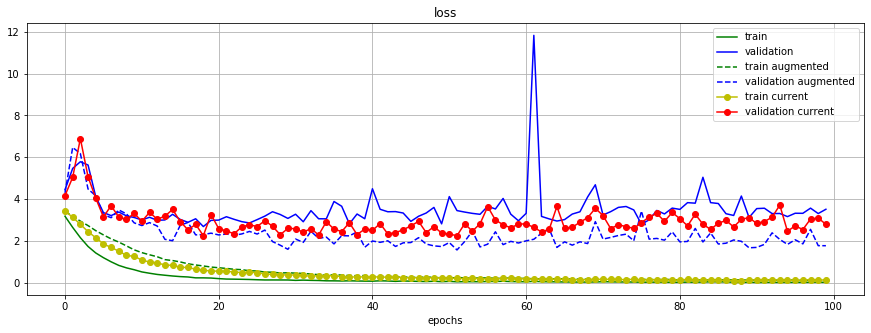

In [58]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

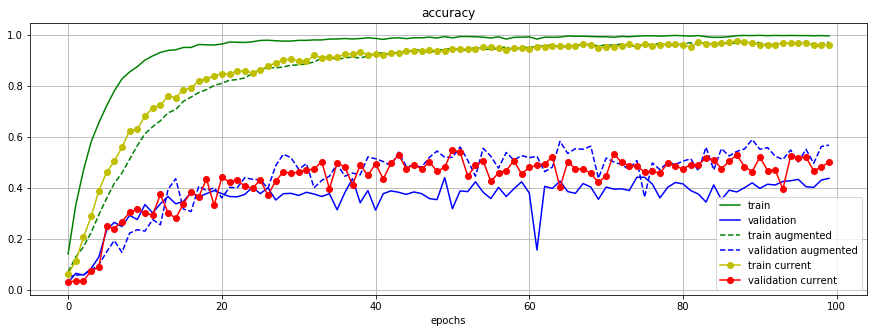

In [59]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

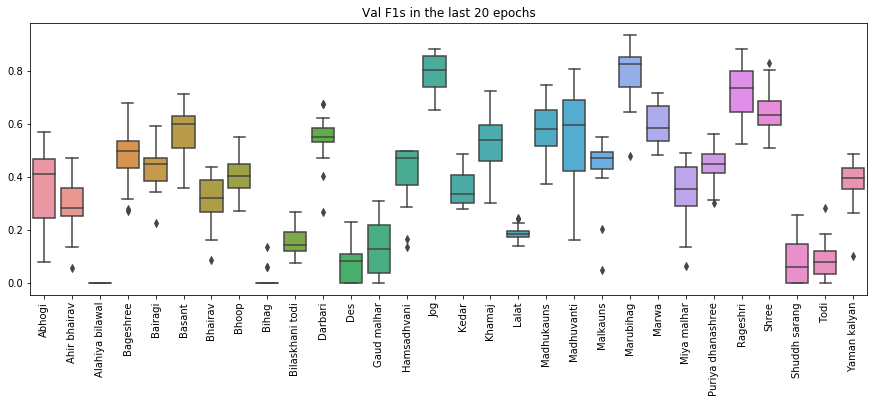

In [60]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

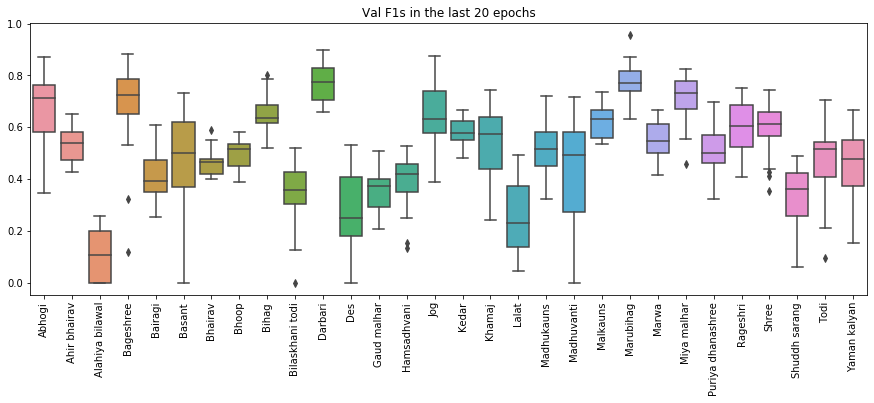

In [89]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

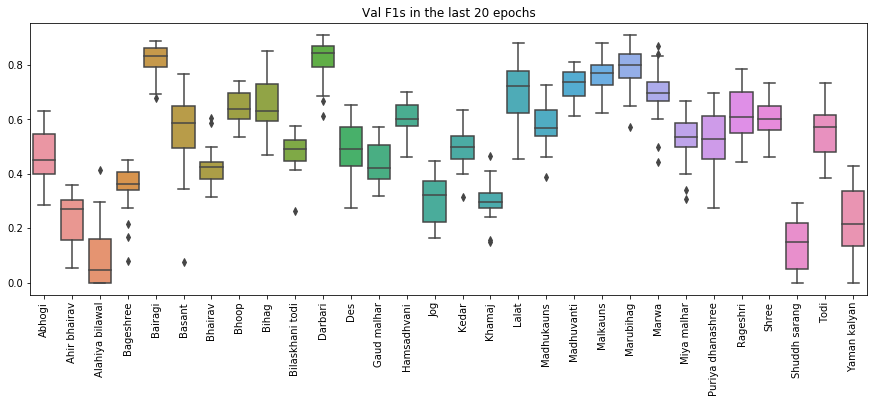

In [90]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

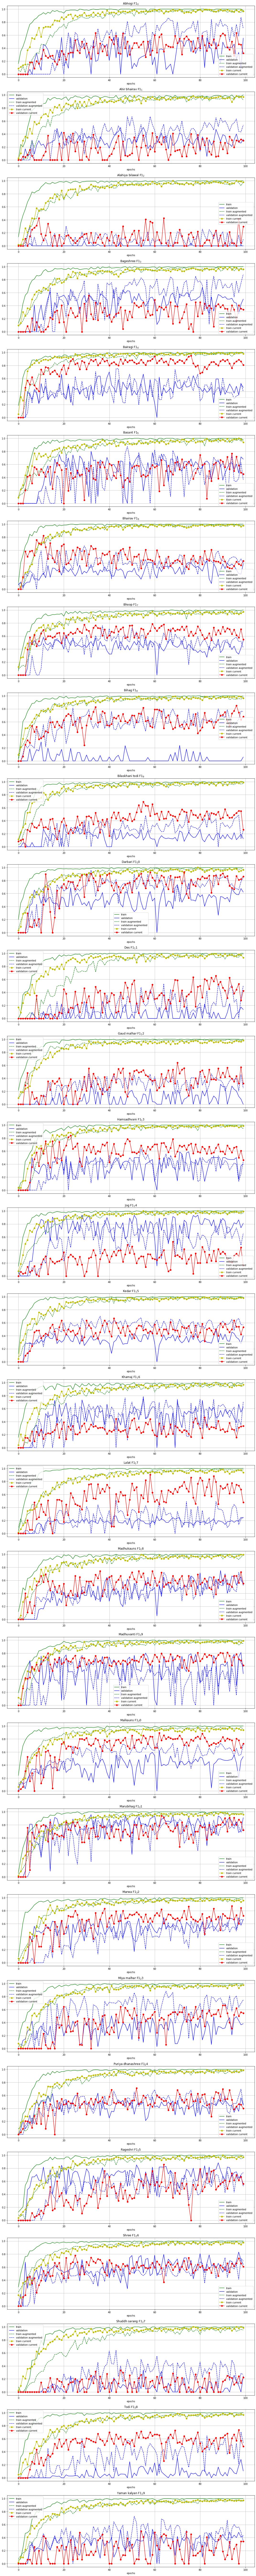

In [91]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    #plt.xticks(range(20),range(1,21))
    plt.grid(True)
plt.tight_layout()

In [92]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [93]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


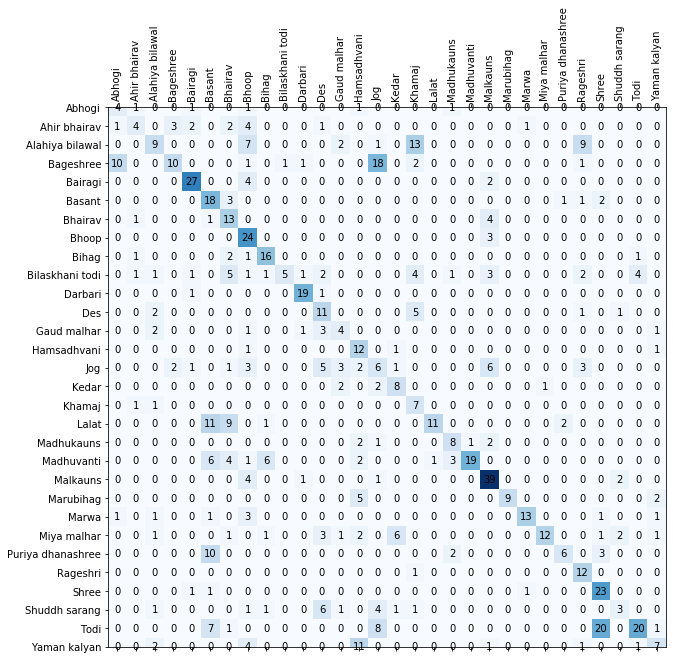

In [94]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [95]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [96]:
precision,recall,f1=process_confusion_matrix(cm)

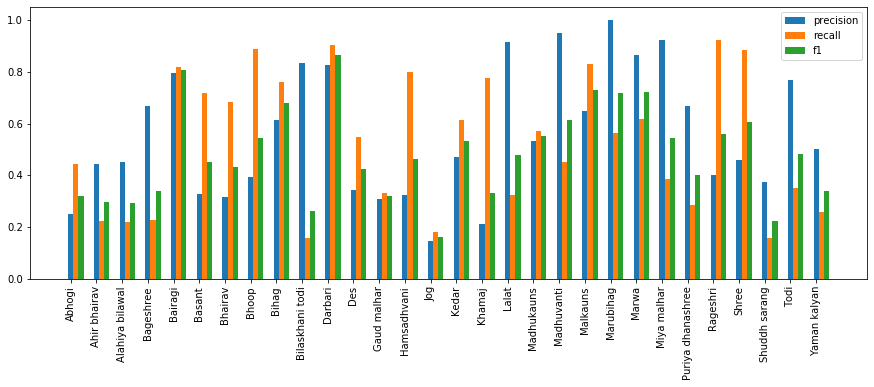

In [97]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()

# work related to periodic padding

Based on https://stackoverflow.com/questions/39088489/tensorflow-periodic-padding

In [301]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([4, 3]), TensorShape([6, 4]))

In [302]:
result=tf.matmul(pre,a)
result

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [308]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])[tf.newaxis,...,tf.newaxis]
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([1, 4, 3, 1]), TensorShape([6, 4]))

In [310]:
tf.transpose(tf.tensordot(pre,a,axes=[1,1]),(1,0,2,3))[0,:,:,0]

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [316]:
pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0))

In [322]:
class PeriodicPadding(keras.layers.Layer):
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        return tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))

In [323]:
pp=PeriodicPadding()


In [328]:
next(iter(train_data))[0][...,tf.newaxis]

<tf.Tensor: shape=(32, 12, 1500, 1), dtype=float32, numpy=
array([[[[0.35395238],
         [0.62483937],
         [0.2514335 ],
         ...,
         [0.03919563],
         [0.02934529],
         [0.04388006]],

        [[0.8546381 ],
         [1.        ],
         [1.        ],
         ...,
         [0.04332115],
         [0.05731897],
         [0.0764455 ]],

        [[1.        ],
         [0.41365883],
         [0.18235262],
         ...,
         [0.84097314],
         [1.        ],
         [1.        ]],

        ...,

        [[0.26271972],
         [0.18089055],
         [0.0787217 ],
         ...,
         [0.09863921],
         [0.1284486 ],
         [0.08776184]],

        [[0.09208088],
         [0.05293678],
         [0.01514117],
         ...,
         [0.11066498],
         [0.06546266],
         [0.09747966]],

        [[0.15809135],
         [0.20290934],
         [0.01715337],
         ...,
         [0.01311859],
         [0.00853989],
         [0.01680734]]],


 

In [329]:
pp(next(iter(train_data))[0][...,tf.newaxis])

<tf.Tensor: shape=(32, 14, 1500, 1), dtype=float32, numpy=
array([[[[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]],

        [[0.01490354],
         [0.0233238 ],
         [0.05875514],
         ...,
         [0.9334802 ],
         [0.6985323 ],
         [0.5537118 ]],

        ...,

        [[0.02656923],
         [0.02724202],
         [0.02169165],
         ...,
         [0.4590119 ],
         [0.10448112],
         [0.02082583]],

        [[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]]],


 

In [335]:
c=keras.layers.Conv2D(5,(3,3), padding='valid')

In [336]:
c(pp(next(iter(train_data))[0][...,tf.newaxis]))

<tf.Tensor: shape=(32, 12, 1498, 5), dtype=float32, numpy=
array([[[[-8.96642953e-02,  1.67192012e-01,  1.22336112e-01,
          -1.19068444e-01,  9.58066359e-02],
         [-3.46585698e-02,  7.98996314e-02,  4.03669477e-02,
          -4.02128436e-02,  3.63214836e-02],
         [-2.91647911e-02,  6.70691654e-02,  2.11968012e-02,
          -1.92416068e-02,  2.24674847e-02],
         ...,
         [-1.34937856e-02,  3.23149301e-02, -1.19507752e-01,
           4.22342382e-02, -1.86150316e-02],
         [-2.89242696e-02, -1.16442721e-02, -1.39085233e-01,
           3.14064734e-02, -4.74732667e-02],
         [ 1.53264939e-03, -1.27264662e-02, -1.15292117e-01,
          -2.16421927e-03, -1.15130302e-02]],

        [[-3.63824517e-02, -7.21778767e-03, -6.31002188e-02,
           7.43871881e-03, -7.56851304e-03],
         [-3.52892838e-03,  1.77940354e-02, -3.32056433e-02,
           2.14235857e-03,  1.07655795e-02],
         [-2.26242933e-02,  1.72086544e-02, -5.05561940e-02,
           1.655

Should try the alternate method which is a bit memory heavy compare to the above



In [360]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9]])[tf.newaxis,...,tf.newaxis]
b = tf.tile(a, [1,3, 1,1])
result = b[:,2:7, :,:]

In [362]:
result[0,:,:,0]

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]], dtype=int32)>